# EFM Holdings Dashboard

## 1. Set up environment

In [27]:
# Set up environment - import libraries, set options, define paths, filenames, import files

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from efm_functions_v2 import *
import os
from copy import deepcopy
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

# Set options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 130)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Import files

In [7]:
# Define file paths and file names, import files
data_path = "Data/"
output_path = "Data/Output/"
bbg_path = "Data/bbg_historical_holdings/dm_sectors/"
crd_path = 'Data/crd_daily_holdings/'

efm_dict = {'MOMG':'BlackRock US MF',
            'MOMN':'Dimensional US MF',
            'MOMP':'Invesco US MF', 
            'MOMS':'Acadian US Value',
            'MOMU':'AB US Growth',
            'MOMX':'BlackRock EU Systematic'}

# Import Data

"""
efm_holdings_data
"""
# "efm_holdings_data" will consist of dataframes from "df_list" which will be a list of DataFrames for each manager   
df_list = []
    
for filename in os.listdir(crd_path):
    df = pd.read_csv(crd_path + filename)
    df_list.append(df)

# "efm_holdings_data" will be a DataFrame (df) containing historical stock holdings of efms defined above, and will be saved as defined below as .csv
efm_holdings_data = pd.concat(df_list).set_index('Effective Date')
efm_holdings_data.index = pd.to_datetime(efm_holdings_data.index)
efm_holdings_data['SEDOL'] = efm_holdings_data['SEDOL'].astype(str)

# Save holdings data as csv file with the output being named with today's date
save_csv(efm_holdings_data, output_path, 'efm_holdings_data')


"""
stock_data
"""
# "stock_data" will contain stock data of MSCI and US and Europe as defined below
stock_data = pd.read_excel(data_path + 'MXUS EU as of Mar 24 20231.xlsx')
stock_data['SEDOL'] = stock_data['SEDOL'].astype(str)


"""
bbg_data
"""
# "bbg_data" contains stock holdings of EFMs from the PORT function on Bloomberg which only contains weekly data up to the past 40 weeks
bbg_df_list = []

# Loop through all the Excel files in the folder
for filename in os.listdir(bbg_path):
    df = pd.read_excel(bbg_path + filename)
    bbg_df_list.append(df)

# "bbg_data" will contain historical stock holdings from bloomberg
bbg_data = pd.concat(bbg_df_list)

# Save holdings data as csv file with the output being named with today's date
# save_csv(bbg_data, output_path, 'bbg_holdings_data')
print('Files successfully imported.')

Files successfully imported.


## 3. Process Data

In [9]:
# Merge efm_holdings_data with stock_data to update holdings data with sector and subinudstry data from stock_data
holdings_merged_1 = pd.merge(efm_holdings_data, stock_data, on='SEDOL', how='left')
holdings_merged_1.index = efm_holdings_data.index

# Count proportion of empty sectors
holdings_merged_1['Sector'].isnull().sum() / len(holdings_merged_1)

"""
bbg_processed
"""

# Process the bloomberg data to tag the sector names, as the data is separated by sector rows and does not have sector column
bbg_processed_list = []

for bbg_df in bbg_df_list:
    df1 = bbg_df.copy()
    df1 = df1.loc[:, ['Name', 'SEDOL1', 'ISIN', 'Ticker']]
    
    # find the index of the separator rows
    sector_indexes = df1[df1['Name'].str.startswith('›')].index.tolist()
    df2 = df1[~df1['Name'].str.startswith('›')]
    df2 = df2.drop(index=0)
    
    # create a list of sectors
    sectors = []
    for i in range(len(sector_indexes)):
        start = sector_indexes[i]
        if i == len(sector_indexes) - 1:
            end = len(df1)
        else:
            end = sector_indexes[i+1]
        sector_name = df1.iloc[start]['Name'][2:]
        sectors.extend([sector_name] * (end - start - 1))
    
    # add the "Sector" column to the dataframe
    df2['Sector'] = sectors
    bbg_processed_list.append(df2)
    
bbg_processed = pd.concat(bbg_processed_list)
bbg_processed = bbg_processed.rename(columns={'SEDOL1': 'SEDOL'})
bbg_processed['SEDOL'] = bbg_processed['SEDOL'].astype(str)
save_csv(bbg_processed, output_path, 'bbg_processed')

# Merge the dataframes to obtain sector and subinudstry data
bbg_processed.drop_duplicates(subset=['SEDOL'], inplace=True)
holdings_merged_2 = pd.merge(holdings_merged_1, bbg_processed, on='SEDOL', how='left')
holdings_merged_2.index = holdings_merged_1.index
holdings_merged_2['Sector_x'] = holdings_merged_2['Sector_x'].fillna(holdings_merged_2['Sector_y'])
holdings_merged_2 = holdings_merged_2.drop('Sector_y', axis=1)
holdings_merged_2 = holdings_merged_2.rename(columns={'Sector_x': 'Sector'})
holdings = holdings_merged_2
save_csv(holdings, output_path, 'holdings')

# Count proportion of empty sectors
proportion = holdings['Sector'].isnull().sum() / len(holdings)

# Replace NaN values in the 'Sector' column with 'Not Classified'
holdings['Sector'].fillna('Null', inplace=True)

# Convert values in the 'Market Value' column to negative floats if they are enclosed in parentheses
holdings['Market Value'] = holdings['Market Value'].str.replace(',', '').str.replace('(', '-', regex=False).str.replace(')', '', regex=False).astype(float)
holdings['Quantity'] = holdings['Quantity'].str.replace(',', '').str.replace('(', '-', regex=False).str.replace(')', '', regex=False).astype(float)

# Display information on processed data
fund_list = list(holdings['Account Code'].unique())
latest_date = holdings.index.max()
number_of_rows = len(holdings)
print(f'Funds: {fund_list} \n'
      f'Latest date: {latest_date:"%Y-%m-%d"} \n'
      f'Missing sectors: {proportion:.2%} \n'
      f'{number_of_rows} rows')

Funds: ['MOMX', 'MOMG', 'MOMN', 'MOMP', 'MOMS', 'MOMU'] 
Latest date: "2023-04-06" 
Missing sectors: 0.23% 
117661 rows


In [13]:
# find the index of the separator rows
df1 = pd.read_excel('Data/bbg_dm_industry_group.xlsx')

industry_group_indexes = df1[df1['Name'].str.startswith('›')].index.tolist()
df2 = df1[~df1['Name'].str.startswith('›')]
df2 = df2.drop(index=0)

# create a list of sectors
industry_groups = []
for i in range(len(industry_group_indexes)):
    start = industry_group_indexes[i]
    if i == len(industry_group_indexes) - 1:
        end = len(df1)
    else:
        end = industry_group_indexes[i+1]
    ig_name = df1.iloc[start]['Name'][2:]
    industry_groups.extend([ig_name] * (end - start - 1))

# add the "Sector" column to the dataframe
df2['Industry Group'] = industry_groups
    
df2 = df2.rename(columns={'SEDOL1': 'SEDOL'})
df2['SEDOL'] = df2['SEDOL'].astype(str)
save_csv(df2, output_path, 'df2')

# Merge the dataframes to obtain sector and subinudstry data
df2.drop_duplicates(subset=['SEDOL'], inplace=True)
holdings_merged_2 = pd.merge(holdings, df2, on='SEDOL', how='left')
holdings_merged_2.index = holdings.index
holdings = holdings_merged_2

# Replace Industry Group values in the 'Sector' column with 'Not Classified'
holdings['Sector'].fillna('Null', inplace=True)

# Display information on processed data
fund_list = list(holdings['Account Code'].unique())
latest_date = holdings.index.max()
number_of_rows = len(holdings)
print(f'Funds: {fund_list} \n'
      f'Latest date: {latest_date:"%Y-%m-%d"} \n'
      f'Missing sectors: {proportion:.2%} \n'
      f'{number_of_rows} rows')

Funds: ['MOMX', 'MOMG', 'MOMN', 'MOMP', 'MOMS', 'MOMU'] 
Latest date: "2023-04-06" 
Missing sectors: 0.23% 
117661 rows


C:\Users\amir.anuar\AppData\Local\Temp\ipykernel_4004\4220938569.py:28: FutureWarning: Passing 'suffixes' which cause duplicate columns {'ISIN_x', 'Name_x'} in the result is deprecated and will raise a MergeError in a future version.
  holdings_merged_2 = pd.merge(holdings, df2, on='SEDOL', how='left')


In [14]:
holdings.to_csv('holdings_industry_group.csv')

In [138]:
holdings

,Account Code,Ticker_x,SEDOL,Security ID,Sec Name,Long/Short,Quantity,Market Value,Accrued Int,Exposure Amt,Currency Cd,ISIN_x,Ticker_y,Name_x,Weight,Shares,Price,Sector,Subindustry,sec mkt cap usd,adjusted weight,Name_y,ISIN_y,Ticker_x,Name_x,# (P)_x,% Wgt (P)_x,Mkt Val (P)_x,# (B)_x,% Wgt (B)_x,% Wgt (D)_x,ISIN_x,Ticker_y,Industry Group_x,Name_y,# (P)_y,% Wgt (P)_y,Mkt Val (P)_y,# (B)_y,% Wgt (B)_y,% Wgt (D)_y,ISIN_y,Ticker,Industry Group_y
Effective Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-30,MOMX,PUB,4380429,19827126,PUBLICIS GROUPE COMMON STOCK EUR.4,L,732.0,43495.44,NaN,NaN,EUR,NaN,PUB FP Equity,Publicis Groupe SA,0.180651,228.466517,71.66,Communication Services,Advertising,19729.289672,0.000377,PUBLICIS GROUPE,FR0000130577,PUB FP,PUBLICIS GROUPE,NaN,NaN,NaN,NaN,0.033462,-0.033462,FR0000130577,PUB FP,Media & Entertainment,PUBLICIS GROUPE,NaN,NaN,NaN,NaN,0.033462,-0.033462,FR0000130577,PUB FP,Media & Entertainment
2022-12-30,MOMX,PSON,677608,19827120,PEARSON PLC COMMON STOCK GBP.25,L,2419.0,25606.94,NaN,NaN,EUR,NaN,NaN,NaN,NaN,NaN,NaN,Consumer Discretionary,NaN,NaN,NaN,PEARSON PLC,GB0006776081,PSON LN,PEARSON PLC,NaN,0.003547,65776.221013,NaN,NaN,0.003547,GB0006776081,PSON LN,Consumer Services,PEARSON PLC,NaN,0.003547,65776.221013,NaN,NaN,0.003547,GB0006776081,PSON LN,Consumer Services
2022-12-30,MOMX,PROX,B00D9P6,19827113,PROXIMUS COMMON STOCK,L,4169.0,37504.32,NaN,NaN,EUR,NaN,NaN,NaN,NaN,NaN,NaN,Communication Services,NaN,NaN,NaN,PROXIMUS,BE0003810273,PROX BB,PROXIMUS,NaN,0.002555,47384.319167,NaN,NaN,0.002555,BE0003810273,PROX BB,Telecommunication Services,PROXIMUS,NaN,0.002555,47384.319167,NaN,NaN,0.002555,BE0003810273,PROX BB,Telecommunication Services
2022-12-30,MOMX,PNDORA,B44XTX8,19827101,PANDORA A/S COMMON STOCK DKK.01,L,447.0,29339.42,NaN,NaN,EUR,NaN,PNDORA DC Equity,Pandora A/S,0.083228,90.725000,619.40,Consumer Discretionary,"Apparel, Accessories & Luxury",8595.152511,0.000164,PANDORA A/S,DK0060252690,PNDORA DC,PANDORA A/S,NaN,NaN,NaN,NaN,0.015665,-0.015665,DK0060252690,PNDORA DC,Consumer Durables & Apparel,PANDORA A/S,NaN,NaN,NaN,NaN,0.015665,-0.015665,DK0060252690,PNDORA DC,Consumer Durables & Apparel
2022-12-30,MOMX,PIRC,BZ5ZHK3,19827091,PIRELLI + C SPA COMMON STOCK NPV,L,2895.0,11591.58,NaN,NaN,EUR,NaN,NaN,NaN,NaN,NaN,NaN,Consumer Discretionary,NaN,NaN,NaN,PIRELLI & C SPA,IT0005278236,PIRC IM,PIRELLI & C SPA,NaN,0.000380,7054.801280,NaN,NaN,0.000380,IT0005278236,PIRC IM,Automobiles & Components,PIRELLI & C SPA,NaN,0.000380,7054.801280,NaN,NaN,0.000380,IT0005278236,PIRC IM,Automobiles & Components
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,MOMP,HUBB,BDFG6S3,50792669,HUBBELL INC COMMON STOCK USD.01,L,249.0,58158.93,NaN,NaN,USD,NaN,HUBB UN Equity,Hubbell Inc,0.035654,53.705829,231.64,Industrials,Electrical Components & Equipm,12410.904977,0.000237,HUBBELL INC,US4435106079,HUBB US,HUBBELL INC,NaN,0.006069,112554.463159,NaN,NaN,0.006069,US4435106079,HUBB US,Capital Goods,HUBBELL INC,NaN,0.006069,112554.463159,NaN,NaN,0.006069,US4435106079,HUBB US,Capital Goods
2023-03-27,MOMP,AGCO,2010278,50924166,AGCO CORP COMMON STOCK USD.01,L,194.0,24936.76,NaN,NaN,USD,NaN,NaN,NaN,NaN,NaN,NaN,Industrials,NaN,NaN,NaN,AGCO CORP,US0010841023,AGCO US,AGCO CORP,NaN,0.001244,23066.600000,NaN,NaN,0.001244,US0010841023,AGCO US,Capital Goods,AGCO CORP,NaN,0.001244,23066.600000,NaN,NaN,0.001244,US0010841023,AGCO US,Capital Goods
2023-03-27,MOMP,TPL,BM99VY2,50792677,TEXAS PACIFIC LAND CORP COMMON STOCK USD.01,L,10.0,16740.20,NaN,NaN,USD,NaN,TPL UN Equity,Texas Pacific Land Corp,0.028968,6.163597,1639.86,Energy,Oil & Gas Exploration & Produc,12619.536071,0.000241,TEXAS PACIFIC LAND CORP,US88262P1021,TPL US,TEXAS PACIFIC LAND CORP,NaN,NaN,NaN,NaN,0.019998,-0.019998,US88262P1021,TPL US,Energy,TEXAS PACIFIC LAND CORP,NaN,NaN,NaN,NaN,0.019998,-0.019998,US88262P1021,TPL US,Energy


## 4. Calculate and plot sector weights over time

In [28]:
industry_weights_df = industry_group_weights(holdings)

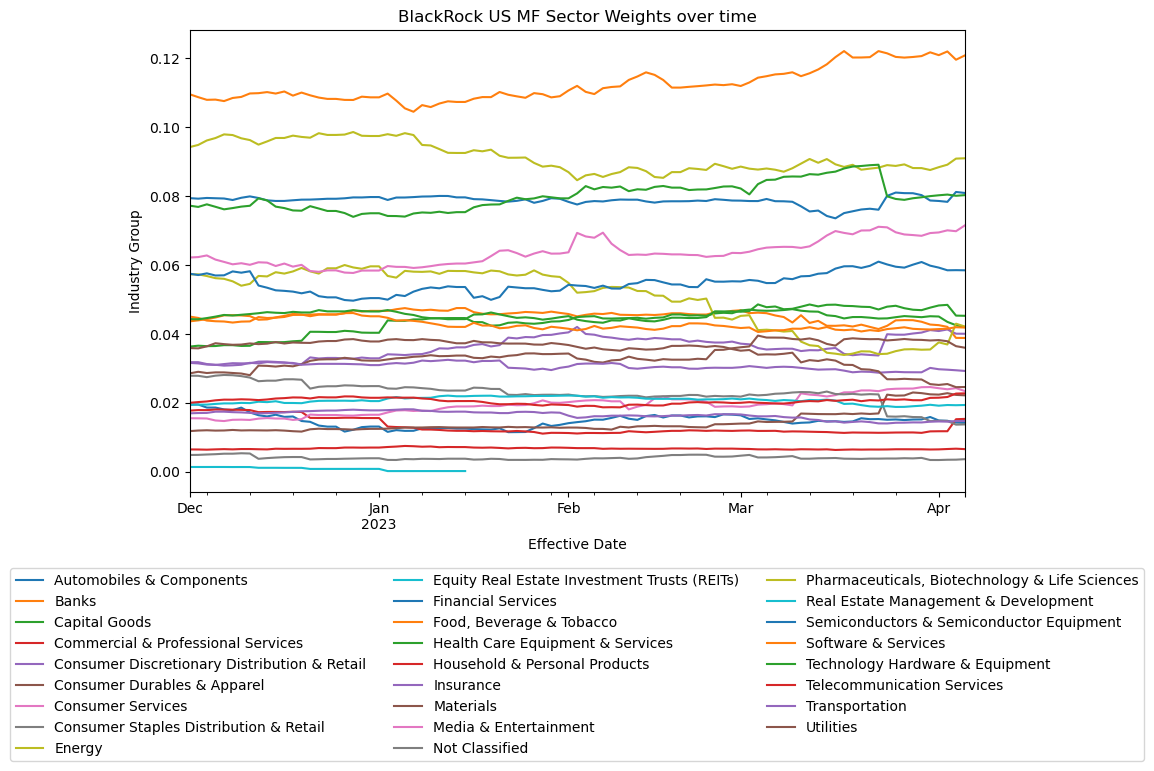

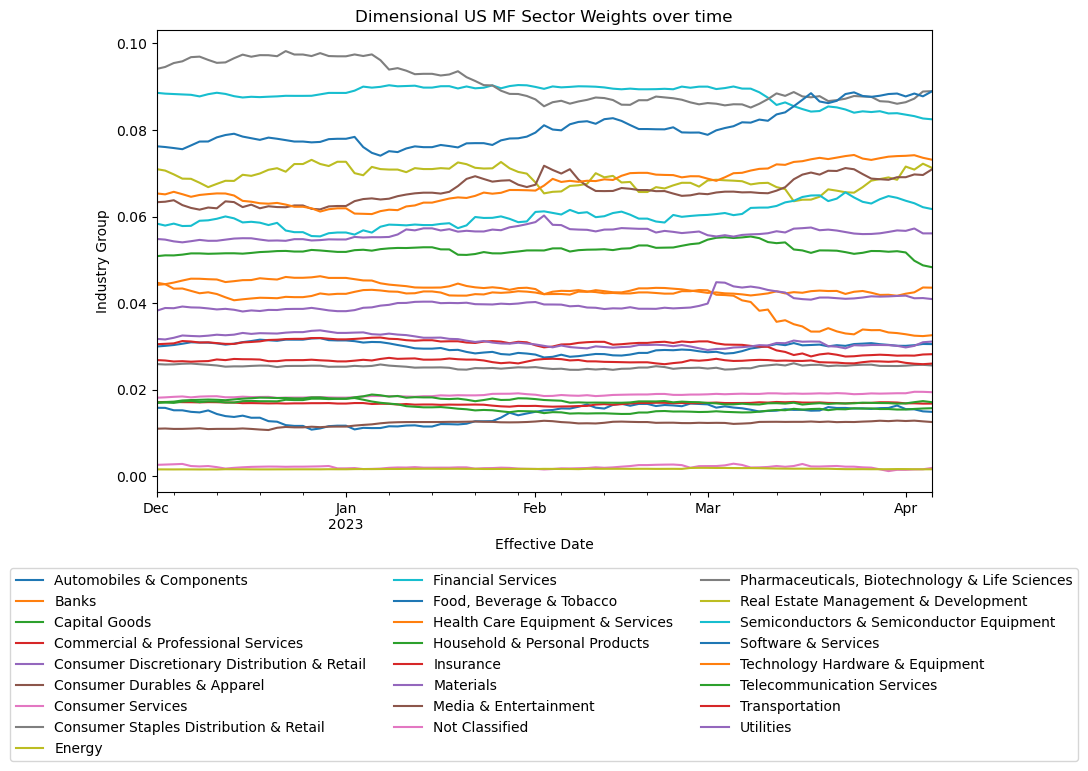

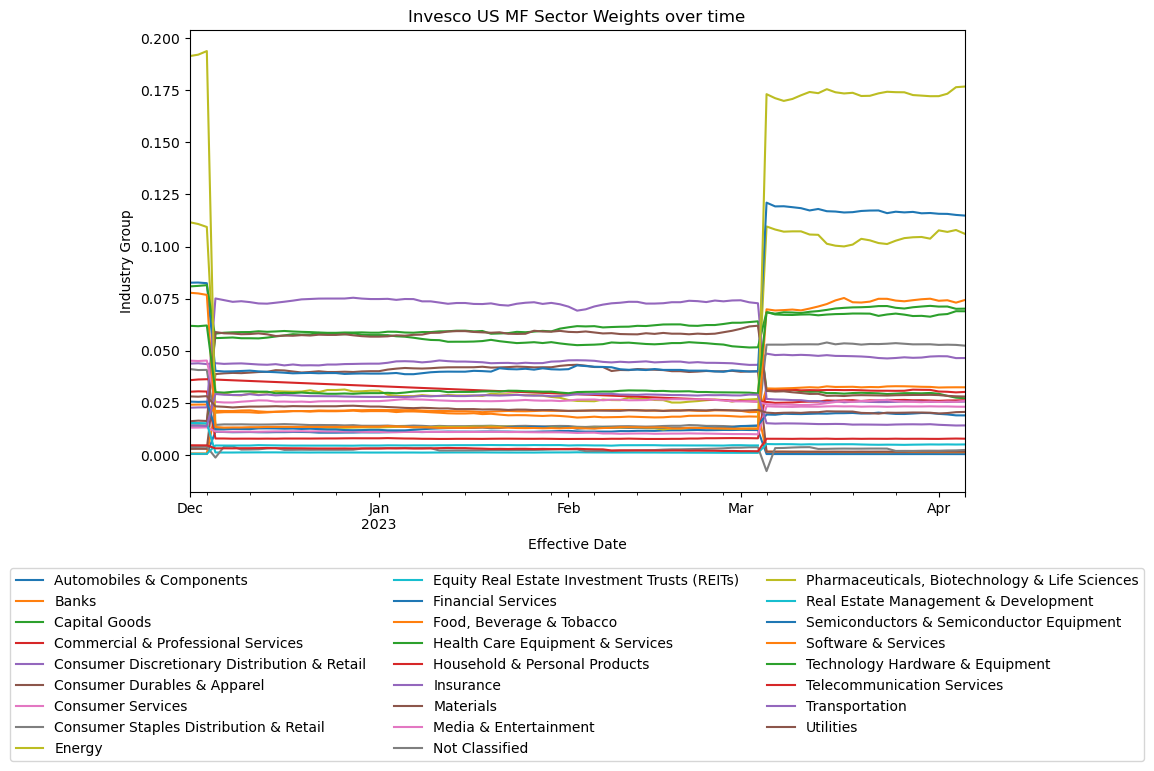

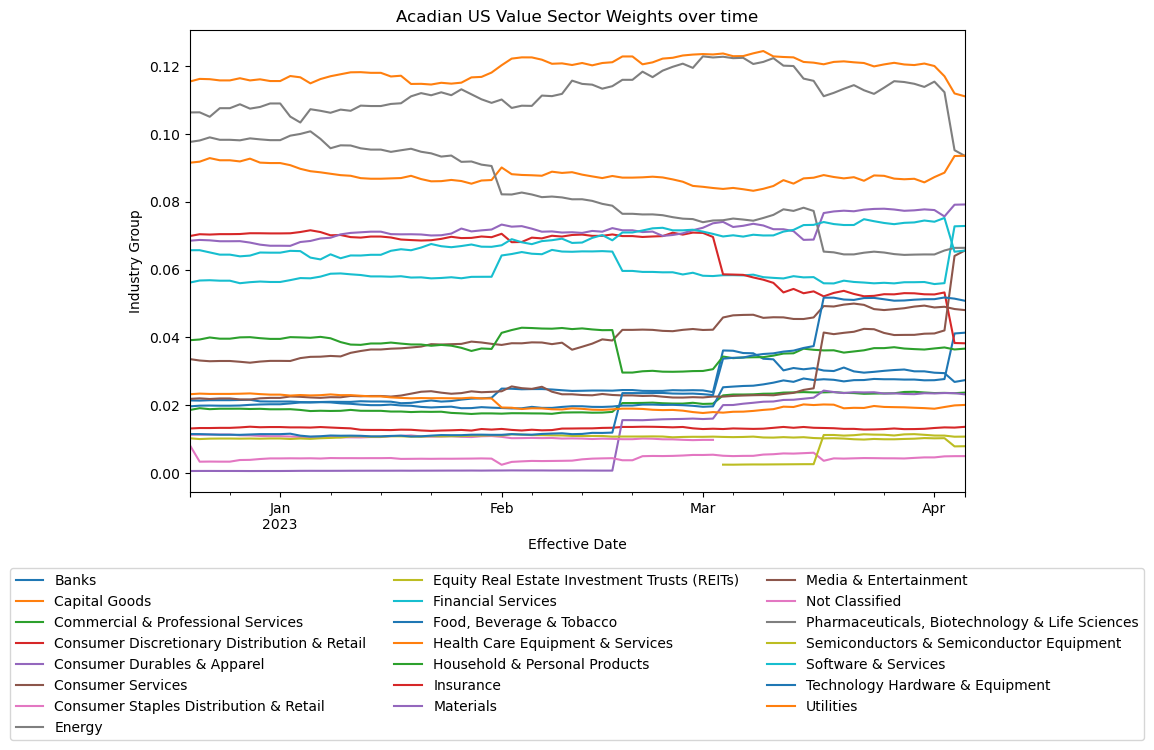

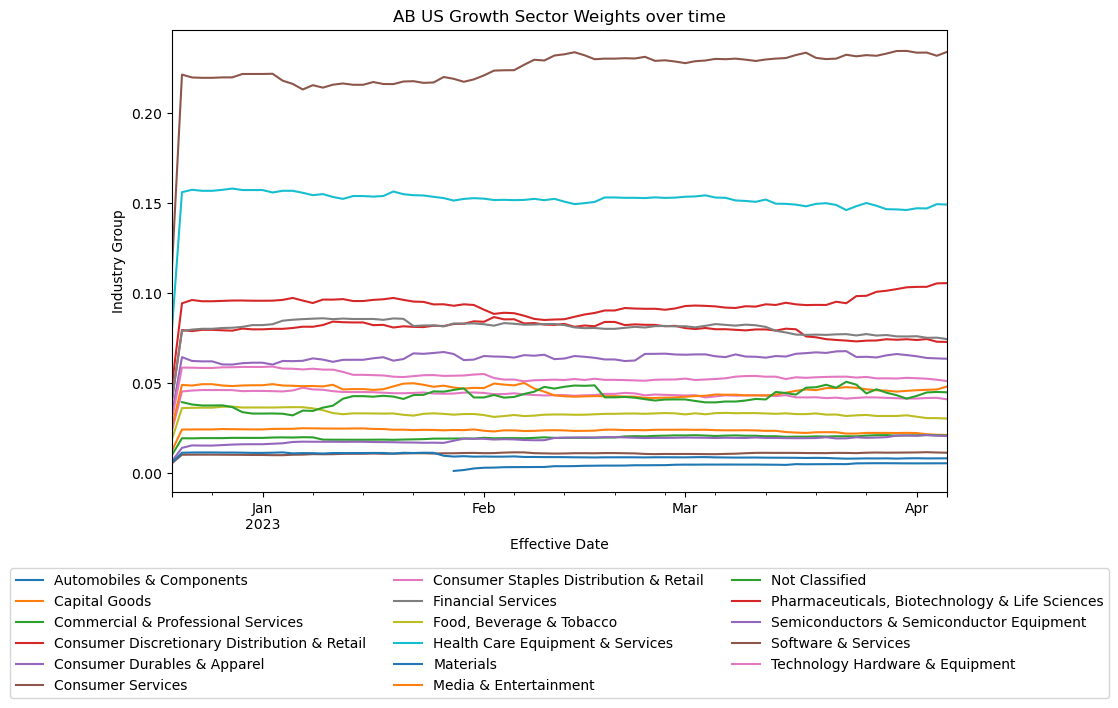

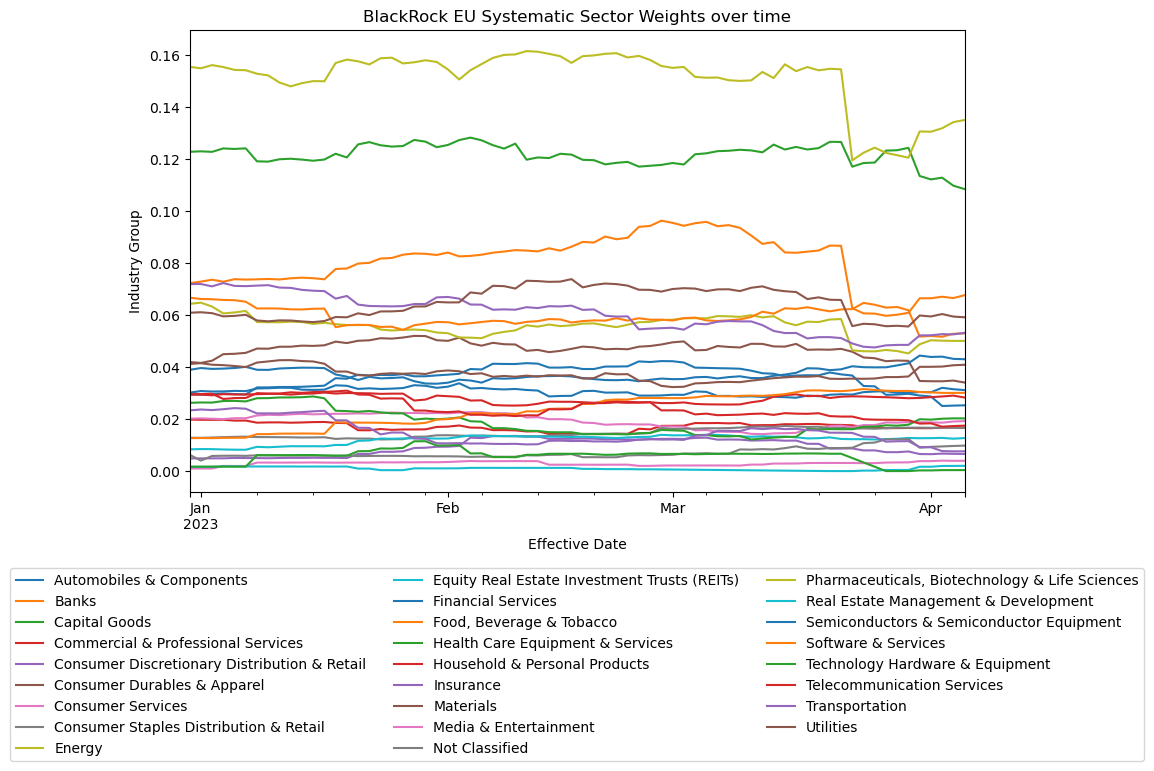

In [145]:
plot_industry_group_weights(industry_weights_df, efm_dict, output_path)

In [29]:
change_windows = [1, 7, 30, 60]
df_changes_list = tabulate_changes_all_ig(industry_weights_df, efm_dict, output_path, change_windows)

,BlackRock US MF,Dimensional US MF,Invesco US MF,Acadian US Value,AB US Growth,BlackRock EU Systematic,Average
Automobiles & Components,-0.01%,-0.01%,-0.00%,nan%,0.00%,-0.03%,-0.01%
Banks,-0.00%,0.02%,0.00%,0.05%,nan%,0.11%,0.04%
Capital Goods,-0.05%,-0.04%,-0.03%,-0.08%,-0.01%,-0.13%,-0.06%
Commercial & Professional Services,0.01%,0.00%,0.02%,0.02%,-0.01%,-0.01%,0.00%
Consumer Discretionary Distribution & Retail,-0.00%,-0.00%,0.00%,0.02%,-0.01%,-0.01%,0.00%
Consumer Durables & Apparel,-0.01%,-0.01%,-0.00%,-0.03%,-0.02%,-0.08%,-0.03%
Consumer Services,-0.08%,-0.01%,-0.00%,-0.03%,-0.01%,0.01%,-0.02%
Consumer Staples Distribution & Retail,0.01%,-0.01%,-0.04%,-0.00%,-0.08%,-0.01%,-0.02%
Energy,-0.08%,-0.09%,-0.18%,-0.16%,nan%,0.00%,-0.10%
Equity Real Estate Investment Trusts (REITs),0.01%,nan%,0.00%,0.00%,nan%,0.03%,0.01%


,BlackRock US MF,Dimensional US MF,Invesco US MF,Acadian US Value,AB US Growth,BlackRock EU Systematic,Average
Automobiles & Components,-0.08%,-0.07%,-0.00%,nan%,-0.00%,0.04%,-0.02%
Banks,-0.52%,-0.12%,-0.01%,-0.30%,nan%,0.79%,-0.03%
Capital Goods,-0.32%,-0.37%,-0.24%,-0.99%,-0.11%,-1.48%,-0.58%
Commercial & Professional Services,0.39%,-0.02%,-0.06%,0.02%,-0.02%,0.02%,0.06%
Consumer Discretionary Distribution & Retail,0.03%,0.01%,-0.03%,0.05%,-0.08%,-0.07%,-0.02%
Consumer Durables & Apparel,0.00%,-0.02%,0.00%,-0.03%,0.09%,-0.82%,-0.13%
Consumer Services,-0.07%,0.03%,-0.02%,-0.03%,-0.01%,0.05%,-0.01%
Consumer Staples Distribution & Retail,-0.24%,-0.02%,-0.09%,-0.04%,-0.10%,0.01%,-0.08%
Energy,0.67%,0.30%,0.21%,-2.20%,nan%,0.35%,-0.13%
Equity Real Estate Investment Trusts (REITs),0.05%,nan%,0.02%,-0.20%,nan%,0.04%,-0.02%


,BlackRock US MF,Dimensional US MF,Invesco US MF,Acadian US Value,AB US Growth,BlackRock EU Systematic,Average
Automobiles & Components,-0.19%,-0.15%,-1.15%,nan%,0.11%,0.09%,-0.26%
Banks,-0.68%,-0.96%,-1.98%,0.31%,nan%,-2.21%,-1.10%
Capital Goods,-0.33%,-0.45%,-3.51%,-1.11%,-0.26%,-1.05%,-1.12%
Commercial & Professional Services,0.35%,-0.01%,2.22%,0.31%,0.04%,0.24%,0.53%
Consumer Discretionary Distribution & Retail,0.24%,-0.04%,0.23%,0.00%,-0.95%,-0.56%,-0.18%
Consumer Durables & Apparel,0.93%,0.02%,-3.87%,0.74%,0.11%,-1.28%,-0.56%
Consumer Services,0.31%,0.06%,1.29%,0.61%,0.07%,0.12%,0.41%
Consumer Staples Distribution & Retail,-0.81%,0.08%,3.85%,-0.13%,-0.22%,0.23%,0.50%
Energy,-0.81%,0.41%,7.99%,-2.51%,nan%,-0.62%,0.89%
Equity Real Estate Investment Trusts (REITs),-0.16%,nan%,0.40%,-0.29%,nan%,-0.02%,-0.02%


,BlackRock US MF,Dimensional US MF,Invesco US MF,Acadian US Value,AB US Growth,BlackRock EU Systematic,Average
Automobiles & Components,0.15%,0.31%,-1.08%,nan%,nan%,-0.09%,-0.18%
Banks,-0.79%,-0.97%,-1.97%,0.62%,nan%,-0.65%,-0.75%
Capital Goods,-0.26%,-0.45%,-3.21%,-0.71%,-0.35%,-1.17%,-1.03%
Commercial & Professional Services,0.34%,0.03%,2.25%,0.54%,0.23%,-0.19%,0.53%
Consumer Discretionary Distribution & Retail,0.43%,-0.07%,0.15%,0.09%,-1.10%,0.15%,-0.06%
Consumer Durables & Apparel,0.93%,0.00%,-4.04%,2.25%,0.33%,-1.38%,-0.32%
Consumer Services,0.47%,0.11%,1.21%,1.21%,0.06%,-0.26%,0.47%
Consumer Staples Distribution & Retail,-0.98%,0.05%,3.87%,nan%,-0.40%,0.36%,0.58%
Energy,-1.61%,0.01%,7.74%,-1.48%,nan%,-0.74%,0.78%
Equity Real Estate Investment Trusts (REITs),-0.27%,nan%,0.39%,-0.29%,nan%,0.31%,0.03%


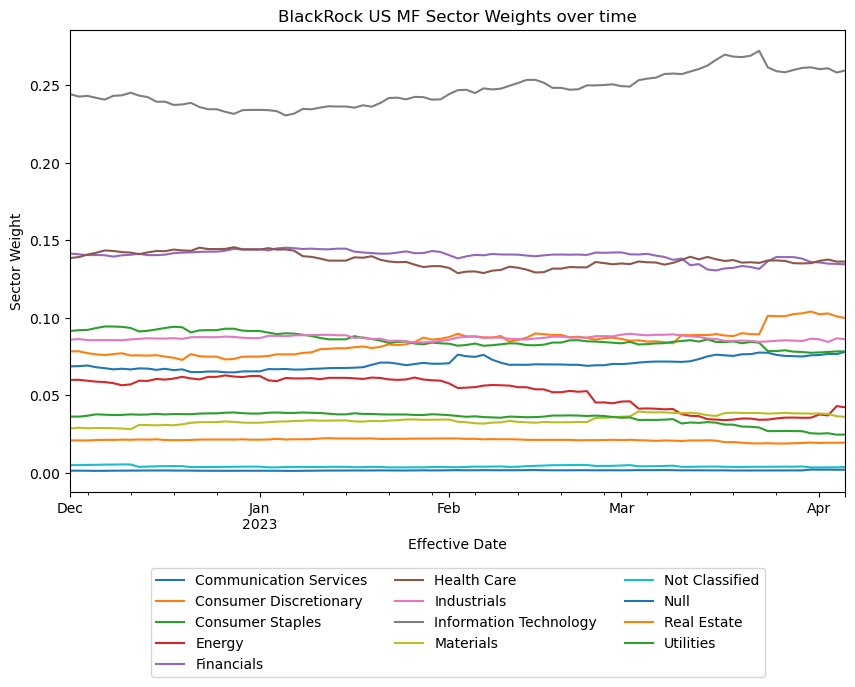

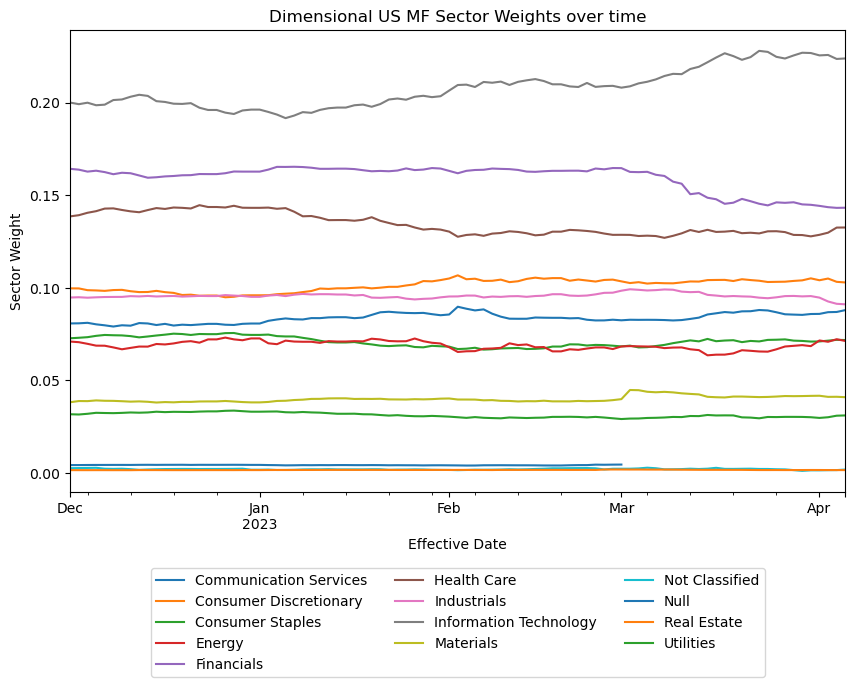

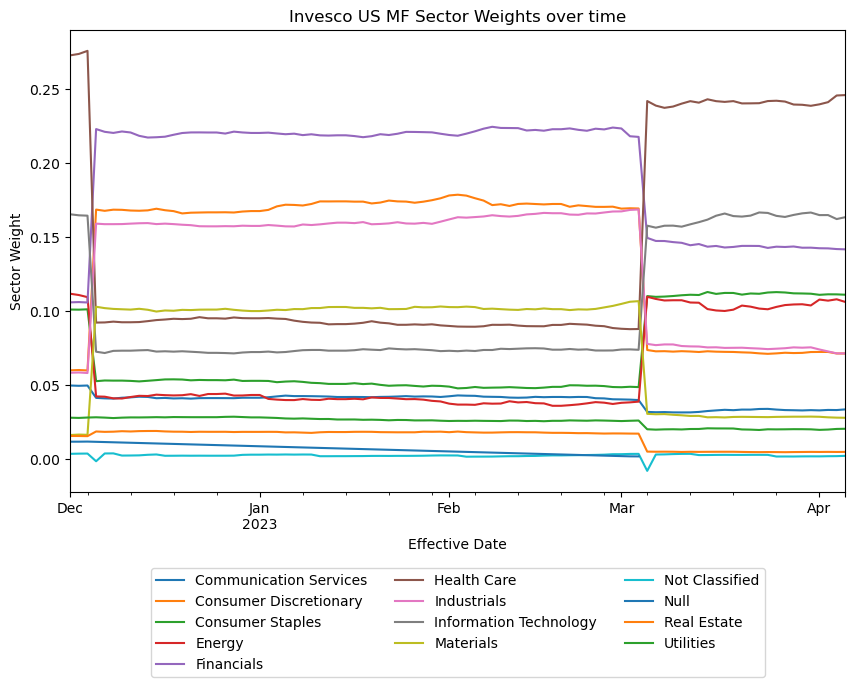

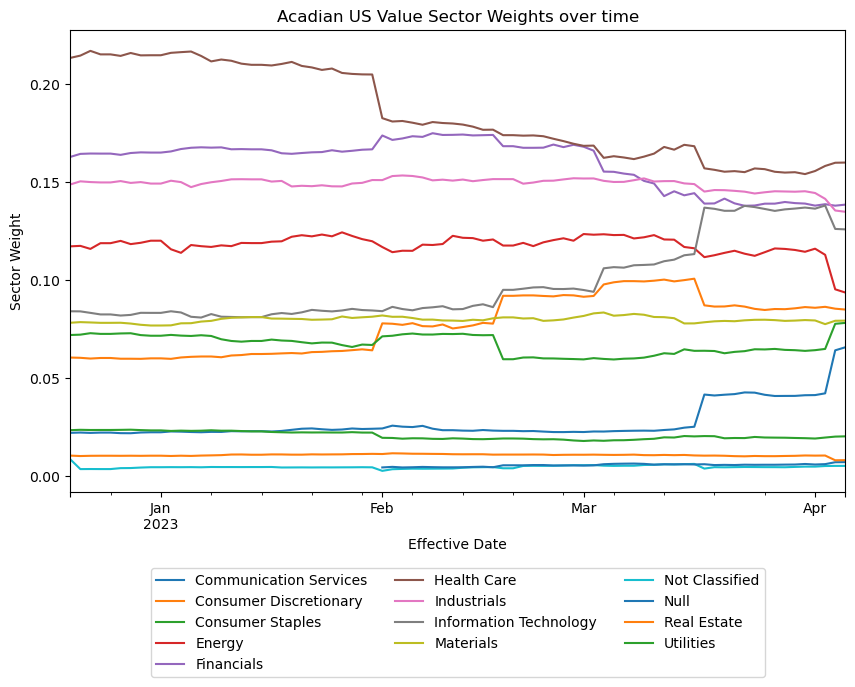

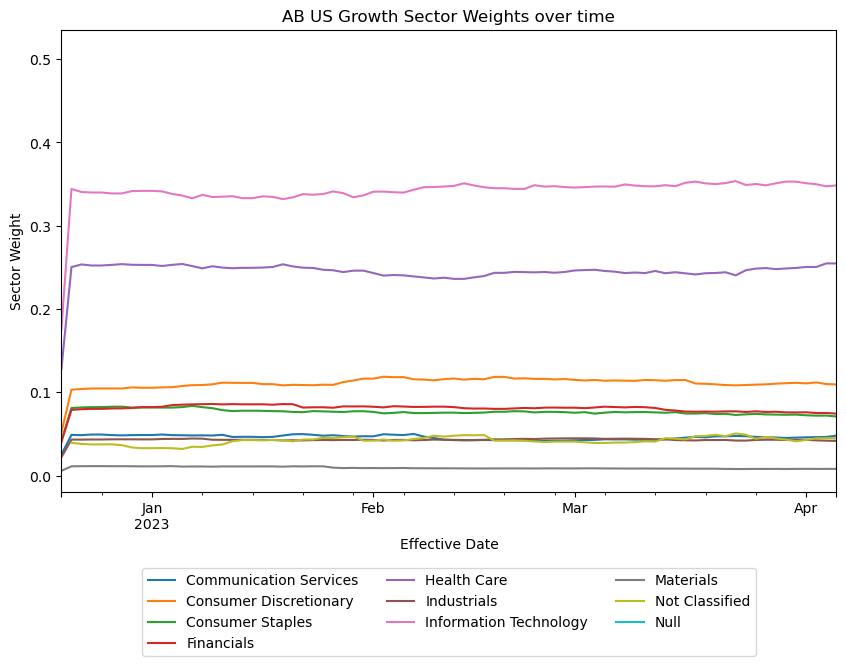

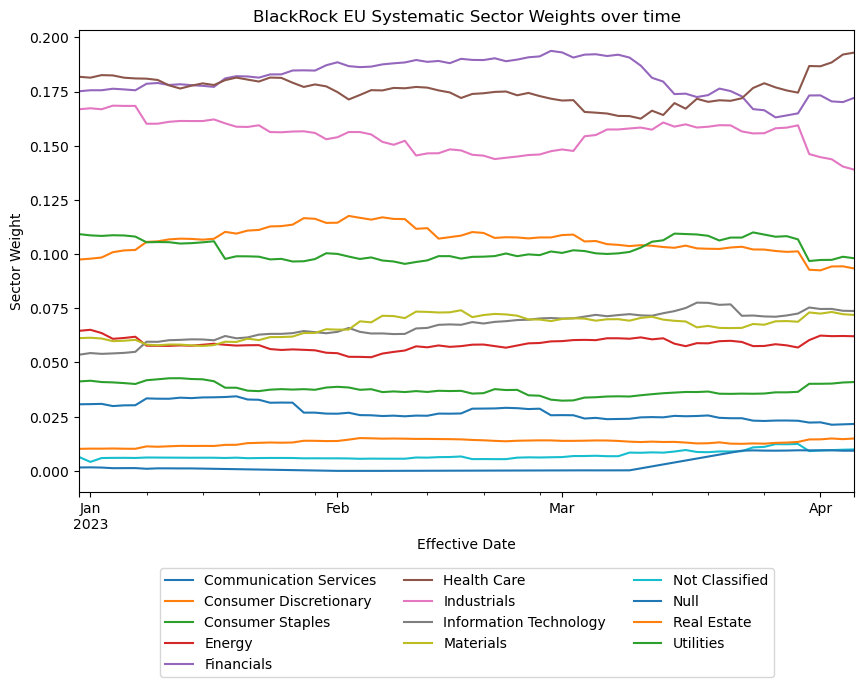

In [4]:
# Calculate sector weights for each day, save into .csv file in output
sector_weights_df = sector_weights(holdings)
save_csv(sector_weights_df, output_path, 'holdings_by_sector')

# Plot sector weight changes for each fund, save as .jpgs in output
plot_sector_weights(sector_weights_df, efm_dict, output_path)

## 6. Tabulate Changes for selected windows

In [5]:
change_windows = [1, 7, 30, 60]
df_changes_list = tabulate_changes_all(sector_weights_df, efm_dict, output_path, change_windows)

,BlackRock US MF,Dimensional US MF,Invesco US MF,Acadian US Value,AB US Growth,BlackRock EU Systematic,Average
Communication Services,0.15%,0.10%,0.05%,0.16%,0.16%,0.02%,0.10%
Consumer Discretionary,-0.11%,-0.03%,-0.00%,-0.04%,-0.04%,-0.10%,-0.05%
Consumer Staples,0.00%,-0.01%,-0.02%,0.05%,-0.10%,-0.07%,-0.03%
Energy,-0.08%,-0.09%,-0.18%,-0.16%,nan%,-0.01%,-0.10%
Financials,-0.03%,0.01%,-0.02%,0.05%,-0.08%,0.20%,0.02%
Health Care,0.00%,0.01%,0.03%,0.01%,-0.01%,0.09%,0.02%
Industrials,-0.06%,-0.03%,-0.00%,-0.07%,-0.03%,-0.14%,-0.05%
Information Technology,0.14%,0.03%,0.13%,-0.02%,0.12%,-0.01%,0.06%
Materials,-0.04%,-0.02%,-0.01%,0.01%,0.00%,-0.03%,-0.02%
Not Classified,0.01%,0.03%,0.02%,0.00%,-0.02%,0.01%,0.01%


,BlackRock US MF,Dimensional US MF,Invesco US MF,Acadian US Value,AB US Growth,BlackRock EU Systematic,Average
Communication Services,0.26%,0.22%,0.05%,2.49%,0.20%,-0.16%,0.51%
Consumer Discretionary,-0.12%,-0.04%,-0.05%,-0.03%,-0.01%,-0.81%,-0.17%
Consumer Staples,-0.07%,-0.04%,-0.15%,1.33%,-0.24%,-0.99%,-0.03%
Energy,0.67%,0.30%,0.21%,-2.25%,nan%,0.37%,-0.14%
Financials,-0.46%,-0.26%,-0.16%,-0.05%,-0.20%,0.90%,-0.04%
Health Care,-0.04%,0.25%,0.44%,0.47%,0.55%,1.60%,0.54%
Industrials,0.07%,-0.44%,-0.35%,-1.05%,-0.14%,-1.91%,-0.64%
Information Technology,0.12%,0.00%,-0.02%,-0.94%,-0.01%,0.26%,-0.10%
Materials,-0.25%,-0.06%,-0.07%,-0.03%,0.01%,0.29%,-0.02%
Not Classified,-0.03%,-0.01%,0.04%,0.06%,-0.17%,-0.24%,-0.06%


,BlackRock US MF,Dimensional US MF,Invesco US MF,Acadian US Value,AB US Growth,BlackRock EU Systematic,Average
Communication Services,0.91%,0.52%,-0.84%,4.31%,0.63%,-0.73%,0.80%
Consumer Discretionary,1.29%,-0.10%,-9.95%,-0.69%,-0.66%,-1.43%,-1.92%
Consumer Staples,-0.65%,0.30%,6.14%,1.81%,-0.48%,-0.10%,1.17%
Energy,-1.04%,0.41%,6.84%,-2.56%,nan%,0.43%,0.81%
Financials,-0.60%,-1.96%,-8.00%,-2.91%,-0.64%,-1.76%,-2.65%
Health Care,0.38%,0.19%,15.49%,-1.35%,1.07%,1.97%,2.96%
Industrials,-0.11%,-0.47%,-9.45%,-1.58%,-0.22%,-0.60%,-2.07%
Information Technology,0.96%,1.32%,8.92%,2.95%,-0.02%,0.42%,2.43%
Materials,0.34%,0.22%,-7.30%,0.01%,-0.05%,0.03%,-1.13%
Not Classified,-0.13%,-0.08%,-0.06%,-0.00%,0.38%,0.38%,0.08%


,BlackRock US MF,Dimensional US MF,Invesco US MF,Acadian US Value,AB US Growth,BlackRock EU Systematic,Average
Communication Services,1.05%,0.39%,-0.87%,4.29%,0.16%,-1.21%,0.64%
Consumer Discretionary,1.99%,0.35%,-10.26%,2.33%,-0.19%,-1.38%,-1.19%
Consumer Staples,-0.78%,0.11%,6.02%,0.96%,-0.64%,-0.68%,0.83%
Energy,-1.90%,0.01%,6.53%,-2.53%,nan%,0.42%,0.51%
Financials,-0.97%,-2.10%,-7.68%,-2.84%,-1.14%,-0.63%,-2.56%
Health Care,-0.06%,-0.40%,15.47%,-5.05%,0.57%,1.66%,2.03%
Industrials,-0.29%,-0.55%,-8.77%,-1.66%,-0.13%,-2.25%,-2.27%
Information Technology,2.31%,2.69%,9.01%,4.49%,1.30%,1.33%,3.52%
Materials,0.24%,0.07%,-7.47%,-0.17%,-0.29%,1.37%,-1.04%
Not Classified,-0.01%,-0.02%,0.02%,0.06%,0.36%,0.38%,0.13%


## 7. Calculate Top Holdings Changes

In [110]:
change_windows = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                  11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                  21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
holdings_changes_dict = holdings_changes(holdings, change_windows)
top_holdings_changes_dict = top_holdings_changes(holdings_changes_dict)
top_holdings_dashboard_dict = top_holdings_dashboard(top_holdings_changes_dict, efm_dict)

,1-day change,2-day change,3-day change,4-day change,5-day change,6-day change,7-day change,8-day change,9-day change,10-day change,11-day change,12-day change,13-day change,14-day change,15-day change,16-day change,17-day change,18-day change,19-day change,20-day change,21-day change,22-day change,23-day change,24-day change,25-day change,26-day change,27-day change,28-day change,29-day change,30-day change
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAPL,0,0,0,0,0,0,0,0,0,-6350,-6350,-6350,-6350,-6350,-6350,-6350,-6350,-6350,-6350,-7128,-7128,-7128,-7128,-7128,-7128,-7128,-7128,-7128,-7128,-7224
MSFT,0,0,0,0,-73,-73,-73,-73,-73,112,112,112,112,112,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389
BRK/B,0,0,0,0,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77
FB,0,0,0,0,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119,505
GOOGL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PG,0,718,718,718,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496
LLY,0,-165,-165,-165,-165,-165,-165,-165,-165,-165,-165,-165,-165,-165,-357,-357,-357,-357,-357,-357,-357,-357,-357,-357,-198,-198,-198,-198,-198,-71
NVDA,0,280,280,280,280,280,280,280,280,1122,1122,1122,1122,1122,1830,1830,1830,1830,1830,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
AMZN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,1-day change,2-day change,3-day change,4-day change,5-day change,6-day change,7-day change,8-day change,9-day change,10-day change,11-day change,12-day change,13-day change,14-day change,15-day change,16-day change,17-day change,18-day change,19-day change,20-day change,21-day change,22-day change,23-day change,24-day change,25-day change,26-day change,27-day change,28-day change,29-day change,30-day change
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAPL,46289,-49889,-77662,-12344,118294,200070,360538,328136,226815,-714500,-650940,-734724,-626094,-487417,-536532,-371275,-348162,-225664,-111834,-349757,-483274,-408903,-539492,-375524,-75696,-40560,-163536,-193402,-122544,-294413
MSFT,198496,120847,119480,90225,185689,282734,427480,395954,281090,412231,558451,517880,560085,364036,528493,818497,943824,1128984,1272638,1172107,1134913,1122785,1049475,1092060,1204719,1335167,1250268,1230323,1255658,1106075
BRK/B,24914,40427,25854,43952,110809,108240,143032,145133,182727,189148,173270,125169,157742,245888,146651,194869,107890,136494,127737,113844,37373,40292,-28007,24764,79636,116179,109641,115712,123184,134275
FB,71961,21495,47195,64796,153391,191879,264063,230676,181677,208418,277510,241186,308424,342430,198371,309352,367006,569802,591288,557591,506892,514003,507974,502564,668263,685421,661926,745394,732255,773159
GOOGL,117046,109638,120306,138974,223129,208313,218980,176607,88303,83562,149642,103712,213350,201498,240019,364770,428182,512930,527153,477075,419885,431442,393809,437665,486557,535154,544044,549674,571601,519449
PG,19025,147303,161055,176717,315117,326843,335088,342600,328492,382176,378511,376862,357624,397932,398665,418087,454364,485695,503101,514460,495955,496322,445203,434210,452898,494489,496322,467373,465174,450700
LLY,48073,50110,81580,140953,163096,202191,187753,212492,200082,228389,241935,241042,220603,256453,190345,190843,210770,232192,310821,295627,331413,347271,278107,282508,360665,367832,391857,347879,306996,300704
NVDA,16680,32390,-20920,-1345,39678,81222,140987,128388,102567,288617,357808,383552,412166,428914,627353,743711,758333,855549,855638,857723,793094,870562,847487,818339,868307,921745,876808,852084,870736,837944
AMZN,26991,-53139,-9841,-34583,1687,50890,135519,113026,110496,94189,94470,40768,122305,87441,56794,164760,201873,270757,318554,275818,228864,239267,233644,201311,279192,278067,220148,233363,240673,175444


,1-day change,2-day change,3-day change,4-day change,5-day change,6-day change,7-day change,8-day change,9-day change,10-day change,11-day change,12-day change,13-day change,14-day change,15-day change,16-day change,17-day change,18-day change,19-day change,20-day change,21-day change,22-day change,23-day change,24-day change,25-day change,26-day change,27-day change,28-day change,29-day change,30-day change
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MSFT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,249,249,437,437,437,437,437,437
AAPL,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221,-221
AMZN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
XOM,0,0,0,0,0,497,845,1286,1286,1286,1892,1892,2367,2367,2648,3261,3261,3261,3261,3261,3261,3261,3261,3261,3261,3261,3261,3261,3261,3261
GOOGL,0,0,0,0,0,0,0,-128,-128,-128,-272,-272,-272,-272,-272,-272,-272,-272,-272,-272,-272,-272,-272,-272,-272,-272,-272,-272,-272,-272
GOOG,0,0,0,0,0,0,0,-230,-230,-230,-514,-514,-514,-514,-514,-514,-514,-514,-514,-514,-514,-514,-514,-514,-514,-514,-514,-514,-514,-514
BRK/B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-141,-337,-520,-520,-520,-520,-520,-520
JNJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,1-day change,2-day change,3-day change,4-day change,5-day change,6-day change,7-day change,8-day change,9-day change,10-day change,11-day change,12-day change,13-day change,14-day change,15-day change,16-day change,17-day change,18-day change,19-day change,20-day change,21-day change,22-day change,23-day change,24-day change,25-day change,26-day change,27-day change,28-day change,29-day change,30-day change
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MSFT,143269,87224,86238,65122,148992,218850,323046,300351,217666,275092,381064,351660,382248,240163,303904,516241,608005,743577,848759,775152,747919,739038,749322,780109,908765,1002162,941377,927097,945236,838138
AAPL,-6129,-69004,-87161,-44459,40943,94404,199307,178125,111888,156270,193255,144502,207713,288408,259829,355991,369440,440721,506958,436686,360025,402727,327747,421892,594041,614215,543607,526459,567143,476697
AMZN,23417,-46103,-8538,-30003,1464,44151,117574,98060,95864,81717,81960,35370,106110,75862,49274,142943,175142,234905,276373,239295,198559,207584,202706,174654,242222,241247,190997,202462,208804,152212
XOM,-34538,534,-19227,95958,98985,162573,231694,300737,338230,340212,384104,345122,466817,507105,517126,570477,493114,498930,480898,461267,448906,425203,393210,407752,428256,435673,449924,440617,437709,437854
GOOGL,65882,61712,67717,78225,125593,117253,123258,86292,36207,33518,56112,29838,92557,85777,107813,179177,215452,263932,272068,243421,210705,217316,195789,220876,248845,276645,281730,284951,297495,267661
GOOG,61517,58870,62140,76313,118051,109018,117428,67248,19836,16676,19317,-6745,56159,47632,69994,142712,179715,221383,231840,205295,173279,181002,158318,183415,210925,239884,243262,246480,258546,230874
BRK/B,10248,16629,10635,18079,35917,34853,49258,50129,65694,68353,61779,41862,55349,91846,50757,70721,34708,46551,42926,37173,5511,6719,-21560,290,23010,38140,35433,37947,41041,45633
FB,30150,9006,19774,27148,53905,70154,100631,86535,65847,77137,106309,90972,119361,133718,72895,119752,144094,229715,238786,224560,203154,206156,177540,138898,180530,188351,177641,215690,209701,198075
JNJ,-3414,49424,61594,75323,86974,87865,98922,87939,92762,104042,104636,83560,83560,94766,82522,80147,83338,89720,100480,103226,90462,82076,71167,82596,94247,93356,88236,70648,68125,55064


,1-day change,2-day change,3-day change,4-day change,5-day change,6-day change,7-day change,8-day change,9-day change,10-day change,11-day change,12-day change,13-day change,14-day change,15-day change,16-day change,17-day change,18-day change,19-day change,20-day change,21-day change,22-day change,23-day change,24-day change,25-day change,26-day change,27-day change,28-day change,29-day change,30-day change
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAPL,0,0,0,0,0,0,0,0,41,41,41,41,41,41,41,41,41,115,115,115,115,115,-261,34637,34637,34637,34637,34637,34637,34637
MSFT,0,0,0,0,0,0,0,0,27,27,27,27,27,27,27,27,27,62,62,62,62,62,-144,18998,18998,18998,18998,18998,18998,18998
XOM,0,0,0,0,0,0,0,0,63,63,63,63,63,63,63,63,63,157,157,157,157,157,-340,46056,46056,46056,46056,46056,46056,46056
BRK/B,0,0,0,0,0,0,0,0,22,22,22,22,22,22,22,22,22,54,54,54,54,54,-122,16094,16094,16094,16094,16094,16094,16094
JNJ,0,0,0,0,0,0,0,0,43,43,43,43,43,43,43,43,43,88,88,88,88,88,-205,27020,27020,27020,27020,27020,27020,27020
CVX,0,0,0,0,0,0,0,0,42,42,42,42,42,42,42,42,42,82,82,82,82,82,-169,23149,23149,23149,23149,23149,23149,23149
V,0,0,0,0,0,0,0,0,25,25,25,25,25,25,25,25,25,55,55,55,55,55,-110,15132,15132,15132,15132,15132,15132,15132
UNH,0,0,0,0,0,0,0,0,12,12,12,12,12,12,12,12,12,19,19,19,19,19,-39,5238,5238,5238,5238,5238,5238,5238
LLY,0,0,0,0,0,0,0,0,18,18,18,18,18,18,18,18,18,26,26,26,26,26,-54,7222,7222,7222,7222,7222,7222,7222


,1-day change,2-day change,3-day change,4-day change,5-day change,6-day change,7-day change,8-day change,9-day change,10-day change,11-day change,12-day change,13-day change,14-day change,15-day change,16-day change,17-day change,18-day change,19-day change,20-day change,21-day change,22-day change,23-day change,24-day change,25-day change,26-day change,27-day change,28-day change,29-day change,30-day change
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAPL,31173,-33598,-52302,-8313,79665,134738,242805,220984,159319,204986,243042,192878,257918,340948,311542,410486,424325,508803,576811,504660,425950,469793,334969,5703328,5703328,5703328,5703328,5703328,5703328,5703328
MSFT,137925,83971,83021,62693,143435,210688,310997,289150,217123,272329,374203,345936,375341,238750,300027,504155,592370,731588,832517,761885,735754,727232,622811,5539817,5539817,5539817,5539817,5539817,5539817,5539817
XOM,-89349,1382,-49740,248242,256071,280481,365224,426018,537088,542607,488335,375652,586760,706802,652070,624934,380251,408663,351749,289785,250771,175955,18414,5298743,5298743,5298743,5298743,5298743,5298743,5298743
BRK/B,34119,55363,35407,60192,119578,116038,163998,166895,225294,234133,212275,146059,190900,312243,175631,242009,122272,171341,159311,140223,35161,39171,-110450,5029536,5029536,5029536,5029536,5029536,5029536,5029536
JNJ,-12429,179953,224266,274253,316674,319917,360177,320187,344314,385319,387477,310862,310862,351598,307086,298453,310053,340141,379192,389157,342834,312401,227232,4462353,4462353,4462353,4462353,4462353,4462353,4462353
CVX,-51622,-32177,-53243,103939,121764,157182,188896,231490,274851,310436,274620,199754,309050,360809,315751,327073,166249,219966,197822,178446,121240,97250,6178,3880930,3880930,3880930,3880930,3880930,3880930,3880930
V,-32988,-25270,-45547,8020,54929,40705,85647,63252,80429,57014,95536,66682,124089,135570,134664,150979,116384,186116,160938,102590,69722,54947,-36443,3419681,3419681,3419681,3419681,3419681,3419681,3419681
UNH,18752,102455,97532,210672,223924,242100,210725,161907,198575,230349,201031,177096,193506,232492,219322,253762,258204,266153,283637,259733,230037,212919,149023,2686099,2686099,2686099,2686099,2686099,2686099,2686099
LLY,43693,98725,126746,179611,199327,234137,221282,243309,238310,263452,275482,274690,256536,288378,285856,286288,303578,324760,392906,379738,410753,424497,339037,2659790,2659790,2659790,2659790,2659790,2659790,2659790


,1-day change,2-day change,3-day change,4-day change,5-day change,6-day change,7-day change,8-day change,9-day change,10-day change,11-day change,12-day change,13-day change,14-day change,15-day change,16-day change,17-day change,18-day change,19-day change,20-day change,21-day change,22-day change,23-day change,24-day change,25-day change,26-day change,27-day change,28-day change,29-day change,30-day change
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FB,0,4675,4675,4675,4675,4675,4675,4675,4675,4675,4675,4675,4675,4675,12727,12727,12727,12727,12727,12727,12727,12727,12727,12727,12727,12727,12727,12727,12727,12727
CSCO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27241,27241,27241,27241,27241,27241,27241,27241,27241,27241,50622,50622,50622,50622,50622,50622
JNJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-7943,-7943,-7943,-7943,-7943,-7943,-7943,-7943,-7943,-7943,-7943,-7943,-7943,-7943,-7943,-7943
ED,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5890,5890,5890,5890,5890,5890
MCK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GOOGL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PEP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CAH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,1-day change,2-day change,3-day change,4-day change,5-day change,6-day change,7-day change,8-day change,9-day change,10-day change,11-day change,12-day change,13-day change,14-day change,15-day change,16-day change,17-day change,18-day change,19-day change,20-day change,21-day change,22-day change,23-day change,24-day change,25-day change,26-day change,27-day change,28-day change,29-day change,30-day change
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FB,58799,1021379,1034665,1043764,1076777,1096827,1134429,1117037,1091512,1105442,1141435,1122512,1157539,1175253,2750305,2750305,2750305,2750305,2750305,2750305,2750305,2750305,2750305,2750305,2750305,2750305,2750305,2750305,2750305,2750305
CSCO,-29189,-29189,-55194,-53336,-8491,5307,46702,38742,40334,81729,96059,31843,17513,57317,1426351,1453730,1453989,1470520,1466645,1460188,1452439,1457605,1444432,1448048,2602100,2602566,2602370,2601610,2602223,2600435
JNJ,-6928,100306,125006,152869,176515,178322,200763,178473,188262,211155,212360,169587,169587,192329,-1055982,-1063343,-1053452,-1033668,-1000312,-991801,-1031368,-1057362,-1091178,-1055752,-1019636,-1022396,-1038269,-1092788,-1100610,-1141097
ED,9039,57970,76246,64848,83517,75853,90002,86464,76639,142273,135002,113583,40481,65634,52468,65438,97469,121443,164086,150920,143059,163300,144238,162710,711736,731827,715314,694673,689031,684627
MCK,-15523,35784,31853,70762,62042,65167,78674,104278,118591,172670,142481,114005,125194,154930,152057,175090,169294,174838,170806,171965,160322,165110,111888,123077,114660,92434,102211,74290,55188,49190
GOOGL,66004,61827,67843,78370,125826,117471,123487,99592,49796,47122,84386,58485,120312,113628,135351,205700,241460,289250,297271,269031,236781,243298,222076,246807,274378,301783,306796,309970,322336,292926
CL,7356,21837,7356,12183,9884,27813,27123,35169,51948,88496,81600,75854,59764,79991,62752,63212,79072,96081,100449,99759,85508,96081,54937,39766,43903,71946,54707,47811,58614,46432
PEP,6775,23619,17503,19385,33217,34723,46391,45827,49591,81961,73868,59754,63706,86854,73868,72739,101910,100216,116025,118190,105862,110285,102193,105486,103886,122612,101910,79514,79044,75750
CAH,-3999,54093,53041,78509,81666,97452,142284,168174,186485,215111,195536,146705,170278,202271,183539,198062,179118,192168,169226,167121,138496,131760,96189,84823,95137,68406,74089,38307,34940,32203


,1-day change,2-day change,3-day change,4-day change,5-day change,6-day change,7-day change,8-day change,9-day change,10-day change,11-day change,12-day change,13-day change,14-day change,15-day change,16-day change,17-day change,18-day change,19-day change,20-day change,21-day change,22-day change,23-day change,24-day change,25-day change,26-day change,27-day change,28-day change,29-day change,30-day change
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MSFT,0,0,0,0,0,0,0,0,270,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120
UNH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28
V,0,0,0,0,0,0,0,0,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,284
GOOG,0,0,0,0,0,0,0,0,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424
USD,-7552,-4242,194951,371353,235374,114206,-41328,182811,-362607,-507063,-100127,-363035,-145254,-99622,299336,315330,242855,766081,766081,786134,788054,807817,808308,808308,789359,745855,711817,717533,794410,634636
AMZN,-210,-210,-210,-210,-210,-670,-670,-670,-337,-337,-337,-337,-337,-337,-2497,-2497,-2497,-2497,-2497,-2497,-2497,-2497,-2497,-2497,-2497,-2497,-2497,-2497,-2497,-2407
VRTX,0,0,0,-80,-80,-80,-80,-80,-190,-190,-470,-470,-470,-597,-597,-597,-597,-597,-597,-597,-597,-597,-597,-597,-597,-597,-597,-597,-597,-597
ZTS,0,0,0,0,0,0,0,0,188,188,188,188,188,188,188,188,-202,-671,-671,-671,-671,-671,-671,-671,-671,-671,-671,-671,-671,-671
COST,0,0,0,0,0,0,0,0,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,73


,1-day change,2-day change,3-day change,4-day change,5-day change,6-day change,7-day change,8-day change,9-day change,10-day change,11-day change,12-day change,13-day change,14-day change,15-day change,16-day change,17-day change,18-day change,19-day change,20-day change,21-day change,22-day change,23-day change,24-day change,25-day change,26-day change,27-day change,28-day change,29-day change,30-day change
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MSFT,268867,163690,161839,122212,279607,410707,606247,563657,484239,549573,747801,692799,750016,484235,603468,1000662,1172312,1425912,1622663,1484974,1434033,1417421,1317015,1375339,1529640,1708304,1592025,1564708,1599407,1394535
UNH,43508,237713,226289,488794,519541,561712,488915,375649,447473,521364,453185,397525,435685,526346,495721,575809,586139,597077,637789,582129,512978,473116,389261,416240,426692,456831,448081,358392,346117,270439
V,-56745,-43470,-78350,13796,94489,70021,147330,108805,178804,138807,204608,155322,253377,272988,271440,299308,240217,348336,305243,205382,149129,123841,31463,108359,229895,247958,207188,196608,217252,189307
GOOG,194095,185742,196061,240776,372466,343966,370501,286966,184521,174779,274155,195238,385710,359892,427604,647792,759834,886003,917667,837289,740348,763731,695044,771038,854339,942024,952254,961997,998532,914744
USD,-7552,-4242,194951,371353,235374,114206,-41328,182811,-362607,-507063,-100127,-363035,-145254,-99622,299336,315330,242855,766081,766081,786134,788054,807817,808308,808308,789359,745855,711817,717533,794410,634636
AMZN,15579,-94300,-34926,-68854,-19119,2235,119667,88456,117622,95187,95574,21693,133868,85904,-172345,-15516,38395,138455,207885,145806,77602,92713,84545,37578,150707,149074,64941,84136,94755,8628
VRTX,-3271,84585,62270,51785,86016,61549,73194,129421,25201,139657,137940,79727,124814,125898,66095,144318,132284,154265,230647,235067,255943,238751,176860,190491,187421,181649,193193,228682,229050,165194
ZTS,28451,41243,28230,55138,105643,138505,86014,71238,135848,200137,197075,90802,99986,129506,89271,149187,63360,12316,55041,-80406,-106541,-69952,-129949,-150175,-105177,-82224,-69270,-34500,-54044,-126085
COST,-77270,-81428,-76576,-75468,-38115,-33888,-5475,-50173,-36645,14979,16629,-6262,4462,19860,18416,29415,55123,123313,129225,71621,26802,32920,47149,100904,29208,77464,39588,19997,9136,-13620


,1-day change,2-day change,3-day change,4-day change,5-day change,6-day change,7-day change,8-day change,9-day change,10-day change,11-day change,12-day change,13-day change,14-day change,15-day change,16-day change,17-day change,18-day change,19-day change,20-day change,21-day change,22-day change,23-day change,24-day change,25-day change,26-day change,27-day change,28-day change,29-day change,30-day change
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NESN,0,0,0,0,0,0,0,796,796,1368,1368,1368,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,2143,2143,2143
ASML,0,0,0,0,168,168,168,267,267,335,335,335,416,416,550,550,550,645,645,645,645,645,645,645,645,645,645,731,731,731
AZN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NOVN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NOVOB,0,0,-84,-84,891,891,891,891,891,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,794,794,794,857,857,735,735,735,561,561,561
ROG,0,0,188,188,391,391,391,156,156,-151,-151,-151,-151,-151,-160,-160,-160,-160,-160,-160,-160,-160,-160,-160,-425,-425,-425,-425,-425,-425
SAP,0,0,-187,-187,-379,-379,-379,-379,-379,-379,-379,-379,-379,-379,-379,-379,-379,-379,-379,-379,-379,-379,-379,-379,-379,-379,-379,-354,-354,48
SU,0,0,0,0,0,0,0,173,173,219,219,219,361,361,361,361,361,361,361,361,361,361,361,361,361,361,361,378,378,378
SIE,0,0,0,0,238,238,238,721,721,1293,1293,1293,1632,1632,1632,1632,1632,1632,1632,1771,1771,1771,1916,1916,2466,2466,2466,2385,2385,1984


,1-day change,2-day change,3-day change,4-day change,5-day change,6-day change,7-day change,8-day change,9-day change,10-day change,11-day change,12-day change,13-day change,14-day change,15-day change,16-day change,17-day change,18-day change,19-day change,20-day change,21-day change,22-day change,23-day change,24-day change,25-day change,26-day change,27-day change,28-day change,29-day change,30-day change
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NESN,17766,70892,50085,60692,85840,57247,98999,179999,177366,258865,260144,290667,297413,279056,268359,288034,302761,309110,343553,355872,367229,376790,380334,329709,332960,383034,355577,358302,358621,348660
ASML,2771,-38797,-37065,-63045,46933,105931,165589,167824,188604,171116,222745,240267,273238,285735,392130,447496,423893,509913,474394,452687,461990,484260,438874,441129,474676,482851,456352,475146,520241,477333
AZN,12759,70158,69852,76808,93222,89899,93019,73109,104645,125323,125839,139211,140980,141359,143897,166486,173932,173819,172662,153730,168809,164466,174369,161947,154457,164623,128655,104501,106879,85764
NOVN,17843,63071,69348,80174,96039,102391,95605,104652,230394,255519,248252,230509,231901,234214,216149,225816,248852,250577,258897,252215,189812,184588,182008,179479,175110,206828,178118,153950,142530,143664
NOVOB,-356,-13150,-30253,-27655,122573,124141,143295,139907,164089,205183,225127,241219,264562,279336,285590,259179,264149,270789,250232,200913,221798,193248,212514,210714,199776,209486,211833,168991,187519,178048
ROG,30893,68675,118415,114262,172966,179447,188786,118115,111527,40925,30130,20033,24362,16957,15168,-20303,-13413,-8891,-1529,5674,804,-3208,-17649,-31673,-100633,-82604,-96972,-108300,-120125,-140221
SAP,7415,6613,-7589,-12284,-27289,-19385,-10442,-16890,-12938,-20217,-10858,-11482,-2123,12020,997,45296,27826,57359,23458,13475,19715,20339,8068,34897,57359,63599,54655,48006,63152,87386
SU,-1754,-46414,-68106,-88044,-83418,-50880,-27434,6420,27329,-24915,-21037,-17935,16164,25301,3982,37331,-24038,5504,-22210,-62412,-43682,-39418,-46880,-41702,-27997,-31652,-20688,-17342,5601,-35879
SIE,-18767,-42858,-47517,-54172,-13899,346,18186,98543,104952,160698,161985,173567,241861,249194,231112,245477,207905,231112,198261,200888,207433,216224,240056,242141,334011,330324,333005,325128,335119,257281


In [124]:
change_windows = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                  11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                  21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

holdings_changes_dict = stock_changes(holdings, change_windows)
holdings_changes_df = stock_changes_df(holdings_changes_dict, efm_dict)
holdings_changes_df.to_csv('holdings_changes_df_6.csv')

2022-12-01 2023-04-06
2023-04-06 2023-04-05
2023-04-05 2023-04-04
2023-04-04 2023-04-03
2023-04-03 2023-03-31
2023-03-31 2023-03-30
2023-03-30 2023-03-29
2023-03-29 2023-03-28
2023-03-28 2023-03-27
2023-03-27 2023-03-24
2023-03-24 2023-03-23
2023-03-23 2023-03-22
2023-03-22 2023-03-21
2023-03-21 2023-03-20
2023-03-20 2023-03-17
2023-03-17 2023-03-16
2023-03-16 2023-03-15
2023-03-15 2023-03-14
2023-03-14 2023-03-13
2023-03-13 2023-03-10
2023-03-10 2023-03-09
2023-03-09 2023-03-08
2023-03-08 2023-03-07
2023-03-07 2023-03-06
2023-03-06 2023-03-03
2023-03-03 2023-03-02
2023-03-02 2023-03-01
2023-03-01 2023-02-28
2023-02-28 2023-02-27
2023-02-27 2023-02-24
2023-02-24 2023-02-23
2022-12-01 2023-04-06
2023-04-06 2023-04-05
2023-04-05 2023-04-04
2023-04-04 2023-04-03
2023-04-03 2023-03-31
2023-03-31 2023-03-30
2023-03-30 2023-03-29
2023-03-29 2023-03-28
2023-03-28 2023-03-27
2023-03-27 2023-03-24
2023-03-24 2023-03-23
2023-03-23 2023-03-22
2023-03-22 2023-03-21
2023-03-21 2023-03-20
2023-03-20

In [125]:
holdings_changes_df

,Ticker_2,SEDOL,Quantity_2,Quantity % Change,Fund,window
0,TEAM,US0494681010,1234.0,0.0,MOMG,0
1,RMBS,2721967,4327.0,0.0,MOMG,0
2,RS,2729068,2672.0,0.0,MOMG,0
3,WBD,BM8JYX3,4329.0,0.0,MOMG,0
4,BOX,BVB3BV2,1169.0,0.0,MOMG,0
...,...,...,...,...,...,...
1261,0,2320148,0.0,NaN,MOMX,29
1262,0,2288406,0.0,NaN,MOMX,29
1263,0,BMFQC33,0.0,NaN,MOMX,29
1264,0,BMBX3P7,0.0,NaN,MOMX,29


In [131]:
ema_dict = holdings_ema(holdings_changes_df)
ema_dict

TypeError: Could not convert B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6B00D9P6 to numeric

{'MOMG': {'0053673': '0053673',
  '0182663': '0182663',
  '0330860': '0330860',
  '0408284': '0408284',
  '0540528': '0540528',
  '0560399': '0560399',
  '0677608': '0677608',
  '0718875': '0718875',
  '0798059': '0798059',
  '0870612': '0870612',
  '0878230': '0878230',
  '0989529': '0989529',
  '182663': '182663',
  '2000019': '2000019',
  '2002305': '2002305',
  '2002479': '2002479',
  '2002554': '2002554',
  '2005973': '2005973',
  '2007281': '2007281',
  '2007849': '2007849',
  '2008154': '2008154',
  '2010278': '2010278',
  '2011602': '2011602',
  '2012605': '2012605',
  '2019952': '2019952',
  '2020415': '2020415',
  '2023607': '2023607',
  '2023748': '2023748',
  '2024332': '2024332',
  '2026082': '2026082',
  '2026242': '2026242',
  '2026361': '2026361',
  '2027342': '2027342',
  '2028174': '2028174',
  '2032067': '2032067',
  '2037062': '2037062',
  '2040640': '2040640',
  '2041308': '2041308',
  '2041364': '2041364',
  '2043274': '2043274',
  '2044545': '2044545',
  '2045247

In [126]:
# Calculate the exponential moving average for each SEDOL across the 30 windows
ema = holdings_changes_df.groupby('SEDOL')['Quantity % Change'].apply(lambda x: x.ewm(span=30).mean())

# Create a new DataFrame with the unique SEDOLs and their respective 30-day EMAs
df_ema = pd.DataFrame({'30-Day EMA': ema})
df_ema.index.name = 'SEDOL'

df_ema

[autoreload of efm_functions failed: Traceback (most recent call last):
  File "C:\Users\amir.anuar\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\amir.anuar\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\amir.anuar\Anaconda3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\amir.anuar\Anaconda3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "C:\Users\amir.anuar\Documents\Pub

,30-Day EMA
SEDOL,
0,0.000000
0,0.000000
0,0.000000
0,-0.063705
0,-0.049985
...,...
1265,0.044428
1265,0.044428
1265,0.044428


In [117]:
holdings

,Account Code,Ticker_x,SEDOL,Security ID,Sec Name,Long/Short,Quantity,Market Value,Accrued Int,Exposure Amt,Currency Cd,ISIN_x,Ticker_y,Name_x,Weight,Shares,Price,Sector,Subindustry,sec mkt cap usd,adjusted weight,Name_y,ISIN_y,Ticker
Effective Date,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-30,MOMX,PUB,4380429,19827126,PUBLICIS GROUPE COMMON STOCK EUR.4,L,732.0,43495.44,NaN,NaN,EUR,NaN,PUB FP Equity,Publicis Groupe SA,0.180651,228.466517,71.66,Communication Services,Advertising,19729.289672,0.000377,PUBLICIS GROUPE,FR0000130577,PUB FP
2022-12-30,MOMX,PSON,677608,19827120,PEARSON PLC COMMON STOCK GBP.25,L,2419.0,25606.94,NaN,NaN,EUR,NaN,NaN,NaN,NaN,NaN,NaN,Consumer Discretionary,NaN,NaN,NaN,PEARSON PLC,GB0006776081,PSON LN
2022-12-30,MOMX,PROX,B00D9P6,19827113,PROXIMUS COMMON STOCK,L,4169.0,37504.32,NaN,NaN,EUR,NaN,NaN,NaN,NaN,NaN,NaN,Communication Services,NaN,NaN,NaN,PROXIMUS,BE0003810273,PROX BB
2022-12-30,MOMX,PNDORA,B44XTX8,19827101,PANDORA A/S COMMON STOCK DKK.01,L,447.0,29339.42,NaN,NaN,EUR,NaN,PNDORA DC Equity,Pandora A/S,0.083228,90.725000,619.40,Consumer Discretionary,"Apparel, Accessories & Luxury",8595.152511,0.000164,PANDORA A/S,DK0060252690,PNDORA DC
2022-12-30,MOMX,PIRC,BZ5ZHK3,19827091,PIRELLI + C SPA COMMON STOCK NPV,L,2895.0,11591.58,NaN,NaN,EUR,NaN,NaN,NaN,NaN,NaN,NaN,Consumer Discretionary,NaN,NaN,NaN,PIRELLI & C SPA,IT0005278236,PIRC IM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,MOMP,HUBB,BDFG6S3,50792669,HUBBELL INC COMMON STOCK USD.01,L,249.0,58158.93,NaN,NaN,USD,NaN,HUBB UN Equity,Hubbell Inc,0.035654,53.705829,231.64,Industrials,Electrical Components & Equipm,12410.904977,0.000237,HUBBELL INC,US4435106079,HUBB US
2023-03-27,MOMP,AGCO,2010278,50924166,AGCO CORP COMMON STOCK USD.01,L,194.0,24936.76,NaN,NaN,USD,NaN,NaN,NaN,NaN,NaN,NaN,Industrials,NaN,NaN,NaN,AGCO CORP,US0010841023,AGCO US
2023-03-27,MOMP,TPL,BM99VY2,50792677,TEXAS PACIFIC LAND CORP COMMON STOCK USD.01,L,10.0,16740.20,NaN,NaN,USD,NaN,TPL UN Equity,Texas Pacific Land Corp,0.028968,6.163597,1639.86,Energy,Oil & Gas Exploration & Produc,12619.536071,0.000241,TEXAS PACIFIC LAND CORP,US88262P1021,TPL US


In [ ]:
for account, acct_group in holdings.groupby('Account Code'):
    